## Stacked Ensembling and Algorithmic Prading Project
### Group 7 - Amy Qejvani, Jinal Khatri, Pranjal Kharbanda

# Data Preparation

In [1]:
using CSV, DataFrames, Plots, Statistics, Flux, MarketData, XGBoost, MarketTechnicals, TimeSeries, DataFrames, GLM

## Preparing FTSE Data

In [2]:
# Load FTSE data
start = DateTime(2009, 4, 17)
ftse = dropmissing(DataFrame(yahoo("^FTSE", YahooOpt(period1 = start,interval="1wk"))))
ftse = select!(ftse, Not([:Open, :High, :Low, :Close]));

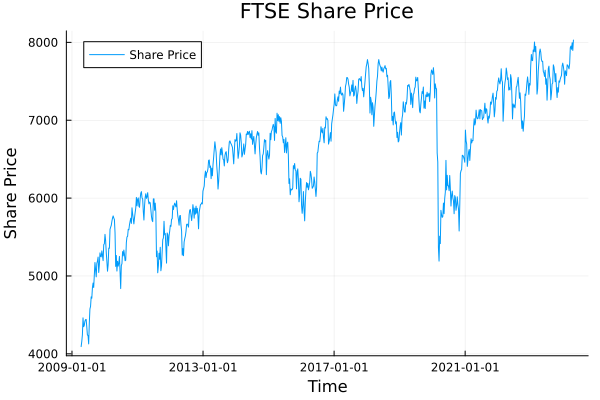

In [3]:
plot(ftse.timestamp, ftse.AdjClose, legend=:topleft, show=true, fmt=png, title="FTSE Share Price", xlabel="Time", ylabel="Share Price", label="Share Price")

In [4]:
# Calculate log returns and truncate
lrt0 = log.((ftse.AdjClose[2:end]) ./ (ftse.AdjClose[1:end-1]))
lrt0[ismissing.(lrt0)] .= 0
lrt = tanh.(lrt0 / 0.03) * 0.03
ftse[:, :lrt] = [0; lrt];

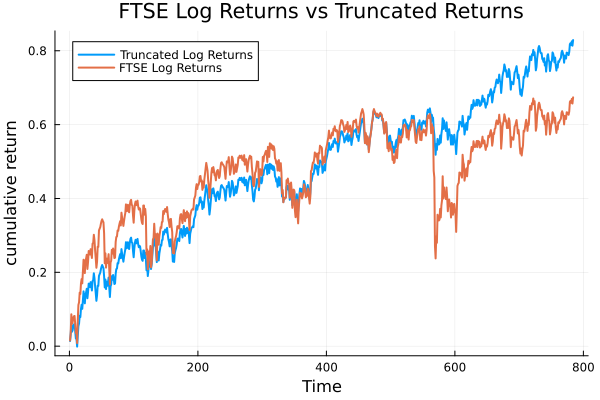

In [5]:
rets = (ftse.AdjClose[2:end]./ftse.AdjClose[1:end-1]).-1;
Plots.plot(cumsum(lrt),label = "Truncated Log Returns", legend=:topleft,show=true,fmt=png,linewidth=2, title="FTSE Log Returns vs Truncated Returns", xlabel="Time", ylabel="Share Price")
plot!(cumsum(lrt0), label= "FTSE Log Returns", legend=:topleft,linewidth=2)
ylabel!("cumulative return")

In [6]:
ta=TimeArray(ftse,timestamp=:timestamp);  # convert DataFrame to TimeArray required for routines

## Adding Technical Indicators

In [7]:
# Prepare TimeArray and indicators
ta = TimeArray(ftse, timestamp=:timestamp)
ema5 = ema(ta[:AdjClose], 5)
ema20 = ema(ta[:AdjClose], 20)
macd1 = macd(ta[:AdjClose], 12, 26, 9)
rsi1 = rsi(ta[:AdjClose]);

In [8]:
# Truncate indicators to align starts
#ema5 = ema5[30:end]
#ema20 = ema20[15:end]
#macd1 = macd1[34:end]
#rsi1 = rsi1[20:end];

In [9]:
ftse2 = ftse[1:end, :]
ftse2 = innerjoin(ftse2, DataFrame(ema5), DataFrame(ema20), DataFrame(macd1), DataFrame(rsi1), on=:timestamp);

In [10]:
ftse2 = ftse[34:end, :]
ftse2 = innerjoin(ftse2, DataFrame(ema5), DataFrame(ema20), DataFrame(macd1), DataFrame(rsi1), on=:timestamp)
DataFrames.rename!(ftse2, :AdjClose_ema_5 => :EMA5)
DataFrames.rename!(ftse2, :AdjClose_ema_20 => :EMA20)
DataFrames.rename!(ftse2, :AdjClose_rsi_14 => :RSI);

In [11]:
n_lags = 12

# Initialize an empty DataFrame for lagged return features
lags = DataFrame()

for lag in 1:n_lags
    lags[!, Symbol("Lag_", lag)] = [zeros(lag); lrt[1:end-lag]]
end

In [12]:
tech_inds = ftse2[1:end,3:10]
if nrow(lags) != nrow(tech_inds)
    resize!(lags, nrow(tech_inds));  # This adjusts lags to have the same number of rows as ftse2
end

752×12 DataFrame
 Row │ Lag_1         Lag_2         Lag_3         Lag_4         Lag_5         L ⋯
     │ Float64       Float64       Float64       Float64       Float64       F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  0.0           0.0           0.0           0.0           0.0            ⋯
   2 │  0.0141168     0.0           0.0           0.0           0.0
   3 │  0.017981      0.0141168     0.0           0.0           0.0
   4 │  0.0279731     0.017981      0.0141168     0.0           0.0
   5 │ -0.0209291     0.0279731     0.017981      0.0141168     0.0            ⋯
   6 │  0.00392525   -0.0209291     0.0279731     0.017981      0.0141168
   7 │  0.0113793     0.00392525   -0.0209291     0.0279731     0.017981
   8 │  0.00463712    0.0113793     0.00392525   -0.0209291     0.0279731
   9 │  0.000765526   0.00463712    0.0113793     0.00392525   -0.0209291      ⋯
  10 │ -0.0186747     0.000765526   0.00463712    0.0113793     0.00392525   -
  11 │ -0.0201613    -0.0186747     0.000765526   0.00463712    0.0113793
  ⋮  │      ⋮             ⋮             ⋮             ⋮             ⋮          ⋱
 743 │ -0.025347      0.0089987    -0.019888      0.0101466    -0.00584405   -
 744 │  0.020028     -0.025347      0.0089987    -0.019888      0.0101466    - ⋯
 745 │  0.0229936     0.020028     -0.025347      0.0089987    -0.019888
 746 │  0.00396158    0.0229936     0.020028     -0.025347      0.0089987    -
 747 │ -0.0154069     0.00396158    0.0229936     0.020028     -0.025347
 748 │ -0.00527316   -0.0154069     0.00396158    0.0229936     0.020028     - ⋯
 749 │ -0.024828     -0.00527316   -0.0154069     0.00396158    0.0229936
 750 │  0.010036     -0.024828     -0.00527316   -0.0154069     0.00396158
 751 │  0.0153948     0.010036     -0.024828     -0.00527316   -0.0154069
 752 │  0.00183142    0.0153948     0.010036     -0.024828     -0.00527316   - ⋯
                                                  7 columns and 731 rows omitted

In [13]:
# Append each technical indicator from ftse2 to the lags DataFrame
for col in names(tech_inds) 
    lags[!, col] = tech_inds[!, col]
end

In [14]:
y = lags.lrt;

In [15]:
# Filter days with no trading
x = Matrix(lags)
x = x[y .!= 0, :]  # Remove rows where trading is zero as per 'y'
y = y[y .!= 0]     # Also filter 'y' to match 'x'

# Check the final sizes
println("Rows in x: ", size(x, 1))
println("Elements in y: ", length(y))

Rows in x: 751
Elements in y: 751


In [16]:
dates = ftse.timestamp
dates = dates[68:end];

In [17]:
x=convert.(Float32,x);  #  This saves memory and makes computation much faster!!!
y=convert.(Float32,y);
ind_all=1:length(y)
ind_te=5:5:length(y)
ind_tr=ind_all[.!in.(ind_all,[ind_te])];

In [18]:
# Calculate the length of in-sample and out-of-sample periods
ilength = length(ind_tr)
olength = length(ind_te)

# Extract dates for in-sample and out-of-sample periods
idates = dates[1:ilength]
odates = dates[end-olength+1:end];

Full : 751
Train : 601
Test : 150

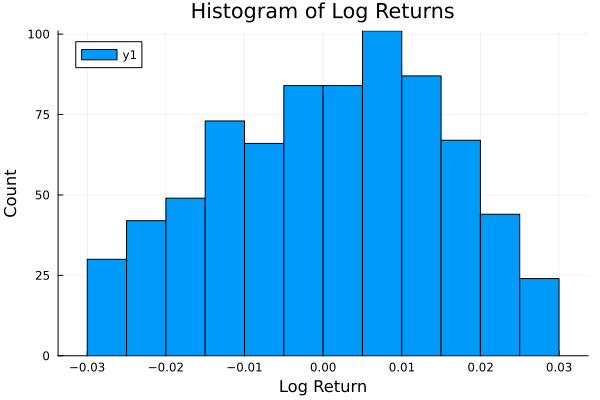

In [19]:
print("Full : ",length(ind_all),"\nTrain : ",length(ind_tr),"\nTest : ",length(ind_te))
histogram(y,legend=:topleft,fmt=png,title="Histogram of Log Returns",xlabel="Log Return",ylabel="Count")

## 5-Fold Training

In [20]:
tr_1 = 1:5:length(ind_tr)
tr_2 = 2:5:length(ind_tr)
tr_3 = 3:5:length(ind_tr)
tr_4 = 4:5:length(ind_tr)
tr_5 = 5:5:length(ind_tr)

5:5:600

In [21]:
kfold_1 = vcat(tr_1,tr_2,tr_3,tr_4);
kfold_1t = vcat(tr_5);
kfold_2 = vcat(tr_1,tr_2,tr_4,tr_5);
kfold_2t = vcat(tr_3);
kfold_3 = vcat(tr_1,tr_2,tr_3,tr_5);
kfold_3t = vcat(tr_4);
kfold_4 = vcat(tr_1,tr_3,tr_4,tr_5);
kfold_4t = vcat(tr_2);
kfold_5 = vcat(tr_2,tr_3,tr_4,tr_5);
kfold_5t = vcat(tr_1);

# Model 1 - Linear Ridge Regression

### Classifying Predictors and Target

In [22]:
# First, ensure that 'lags' DataFrame includes the technical indicators
for col in names(tech_inds)
    lags[!, col] = tech_inds[!, col]
end

X = Matrix(lags)
y = ftse2[:, :lrt]

# To ensure that 'y' only includes days where trading occurred (non-zero log returns), we filter both 'X' and 'y'
is_trading_day = y .!= 0
X = X[is_trading_day, :]
y = y[is_trading_day]

# Convert the data to Float32 if necessary (for efficiency and memory saving)
X = convert.(Float32, X)
y = convert.(Float32, y);

### Training the model

In [23]:
# Split the data again and retrain the model.
train_size = floor(Int, size(X, 1) * 0.8)
X_train = X[1:train_size, :]
X_test = X[(train_size + 1):end, :]
y_train = y[1:train_size]
y_test = y[(train_size + 1):end];

In [24]:
using LinearAlgebra

# Add a column of ones to X_train for the intercept term
X_train_with_intercept = hcat(ones(size(X_train, 1)), X_train)

# Define the regularization strength (lambda)
lambda = 1.0  # This is just an example value

# Compute the ridge regression coefficients manually using the normal equation with regularization
ridge_coef = inv(X_train_with_intercept' * X_train_with_intercept + lambda * I) * X_train_with_intercept' * y_train;

### Running the Ridge Regression

In [25]:
wts = ones(size(ftse2[!, :lrt])) * lambda

ridge_model = glm(@formula(lrt ~ EMA5 + EMA20 + RSI), ftse2, Normal(), IdentityLink(), wts=wts)

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Normal{Float64}, IdentityLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

lrt ~ 1 + EMA5 + EMA20 + RSI

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error       z  Pr(>|z|)     Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.0564792   0.0047406   -11.91    <1e-31  -0.0657706    -0.0471878
EMA5         -6.35724e-5  4.10755e-6  -15.48    <1e-53  -7.1623e-5    -5.55217e-5
EMA20         6.38649e-5  4.18023e-6   15.28    <1e-51   5.56718e-5    7.2058e-5
RSI           0.00107124  4.89542e-5   21.88    <1e-99   0.000975287   0.00116718
─────────────────────────────────────────────────────────────────────────────────

### Splitting the Data

In [26]:
# Determine the size of the training set as 80% of the total data
train_size = floor(Int, size(X, 1) * 0.8)

# Split the predictors (X) into training and testing sets based on the calculated size
X_train = X[1:train_size, :]
X_test = X[(train_size + 1):end, :]

# Split the target (y) into training and testing sets in the same manner
y_train = y[1:train_size]
y_test = y[(train_size + 1):end]

# Confirm the dimensions
println("Size of X_train: ", size(X_train))
println("Size of X_test: ", size(X_test))
println("Size of y_train: ", length(y_train))
println("Size of y_test: ", length(y_test))

# Check if the number of columns in X_train matches X_test
if size(X_train, 2) == size(X_test, 2)
    println("Feature dimensions match.")
else
    println("Feature dimensions do not match.")
end


Size of X_train: (600, 20)
Size of X_test: (151, 20)
Size of y_train: 600
Size of y_test: 151
Feature dimensions match.


### Checking the dimensions of the training and test sets

In [27]:
# Calculate means and standard deviations from the training set
means = mean(X_train, dims=1)
stds = std(X_train, dims=1)

# Normalize the training data
X_train_norm = (X_train .- means) ./ stds

# Normalize the test data using the same means and standard deviations
X_test_norm = (X_test .- means) ./ stds;


In [28]:
println("Size of X_train after preprocessing: ", size(X_train_norm))
println("Size of X_test after preprocessing: ", size(X_test_norm))

Size of X_train after preprocessing: (600, 20)
Size of X_test after preprocessing: (151, 20)


In [29]:
println(size(X_train))  # Should print (number_of_train_samples, number_of_features)
println(size(X_test))   # Should print (number_of_test_samples, number_of_features)

(600, 20)
(151, 20)


### In-Sample Predictions

In [30]:
# Add intercept to X_train if not already included
if size(X_train, 2) == size(ridge_coef, 1) - 1
    X_train_with_intercept = hcat(ones(size(X_train, 1)), X_train)
else
    X_train_with_intercept = X_train
end

# Perform in-sample prediction
in_sample_predictions = X_train_with_intercept * ridge_coef;

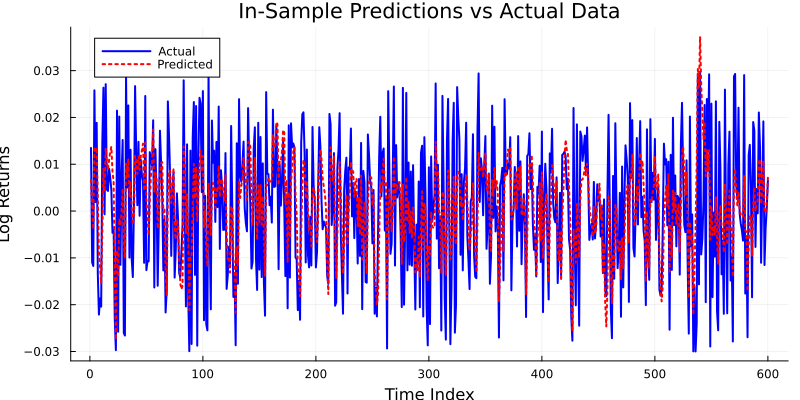

In [31]:
# Plot the actual vs predicted values
plot_fig = plot(size=(800, 400))  # Set the size of the plot window

# Plotting the actual data
plot!(plot_fig, y_train, label="Actual", linewidth=2, color=:blue)

# Plotting the predicted data
plot!(plot_fig, in_sample_predictions, label="Predicted", linewidth=2, color=:red, linestyle=:dot)

# Adding titles and labels
title!(plot_fig, "In-Sample Predictions vs Actual Data")
xlabel!(plot_fig, "Time Index")
ylabel!(plot_fig, "Log Returns")

# Display the plot
display(plot_fig)


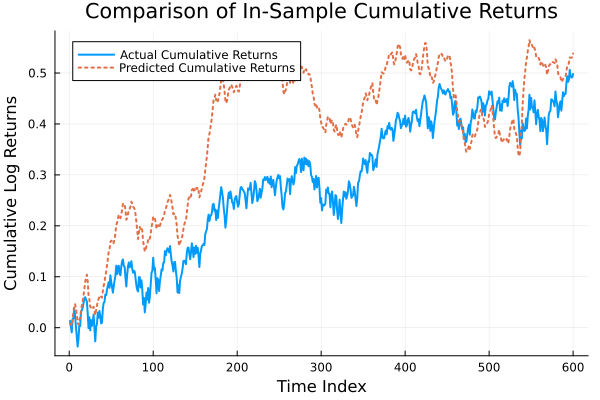

In [32]:
# Calculate cumulative sums
cumulative_actual_returns = cumsum(y_train)
cumulative_predicted_returns = cumsum(in_sample_predictions)

# Plotting the actual cumulative returns
isplot = plot(cumulative_actual_returns, label="Actual Cumulative Returns", show=true,  linewidth=2)

# Plotting the predicted cumulative returns
plot!(isplot, cumulative_predicted_returns, label="Predicted Cumulative Returns", linewidth=2, linestyle=:dot)

# Adding titles and labels
title!(isplot, "Comparison of In-Sample Cumulative Returns")
xlabel!(isplot, "Time Index")
ylabel!(isplot, "Cumulative Log Returns")

# Display the plot
display(isplot)


### Out-of Sample Predictions

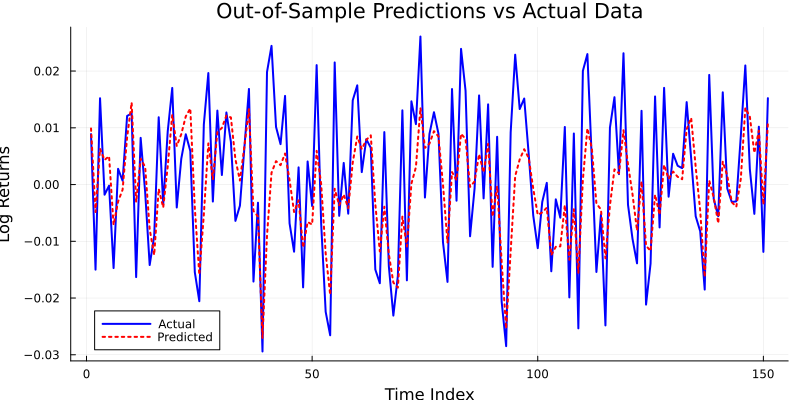

In [33]:
# Add intercept to X_test if not already included
if size(X_test, 2) == size(ridge_coef, 1) - 1
    X_test_with_intercept = hcat(ones(size(X_test, 1)), X_test)
else
    X_test_with_intercept = X_test
end

# Perform out-of-sample prediction
out_of_sample_predictions = X_test_with_intercept * ridge_coef

# If you want to plot these predictions as well, you can follow the same method used for in-sample predictions:
plot_out_of_sample = plot(size=(800, 400))

# Plotting the actual data for out-of-sample
plot!(plot_out_of_sample, y_test, label="Actual", linewidth=2, color=:blue)

# Plotting the predicted data for out-of-sample
plot!(plot_out_of_sample, out_of_sample_predictions, label="Predicted", linewidth=2, color=:red, linestyle=:dot)

# Adding titles and labels for out-of-sample plot
title!(plot_out_of_sample, "Out-of-Sample Predictions vs Actual Data")
xlabel!(plot_out_of_sample, "Time Index")
ylabel!(plot_out_of_sample, "Log Returns")

# Display the plot
display(plot_out_of_sample)

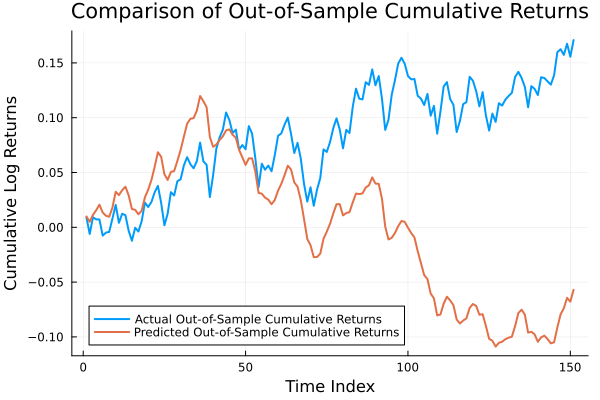

In [34]:
# Calculate cumulative sums for actual and predicted returns
cumulative_actual_returns_test = cumsum(y_test)  # Assuming y_test is your out-of-sample actual data
cumulative_predicted_returns_test = cumsum(out_of_sample_predictions)

# Start a new plot with the actual out-of-sample cumulative returns
plot_out_of_sample = plot(cumulative_actual_returns_test, label="Actual Out-of-Sample Cumulative Returns", linewidth=2, fmt=png )

# Add the predicted out-of-sample cumulative returns
plot!(plot_out_of_sample, cumulative_predicted_returns_test, label="Predicted Out-of-Sample Cumulative Returns", linewidth=2)

# Adding titles and labels
title!(plot_out_of_sample, "Comparison of Out-of-Sample Cumulative Returns")
xlabel!(plot_out_of_sample, "Time Index")
ylabel!(plot_out_of_sample, "Cumulative Log Returns")

# Display the plot
display(plot_out_of_sample)

### Sharpe Ratio

In [35]:
daily_returns_in_sample = [sign(pred) == sign(actual) ? abs(actual) : -abs(actual) for (pred, actual) in zip(in_sample_predictions[2:end], y_train[2:end])]
daily_returns_out_of_sample = [sign(pred) == sign(actual) ? abs(actual) : -abs(actual) for (pred, actual) in zip(out_of_sample_predictions[2:end], y_test[2:end])]

mean_daily_return_in_sample = mean(daily_returns_in_sample)
mean_daily_return_out_of_sample = mean(daily_returns_out_of_sample)

std_daily_return_in_sample = std(daily_returns_in_sample)
std_daily_return_out_of_sample = std(daily_returns_out_of_sample)

risk_free_rate_in_sample = 0.0005  # Example placeholder value
risk_free_rate_out_of_sample = 0.0005  # Example placeholder value

# Calculate the Sharpe Ratio for in-sample predictions
sharpe_ratio_in_sample = (mean_daily_return_in_sample - risk_free_rate_in_sample) / std_daily_return_in_sample

# Calculate the Sharpe Ratio for out-of-sample predictions
sharpe_ratio_out_of_sample = (mean_daily_return_out_of_sample - risk_free_rate_out_of_sample) / std_daily_return_out_of_sample

println("In-Sample Sharpe Ratio: ", sharpe_ratio_in_sample)
println("Out-of-Sample Sharpe Ratio: ", sharpe_ratio_out_of_sample)


In-Sample Sharpe Ratio: 0.728291715971954
Out-of-Sample Sharpe Ratio: 0.7292112326939733


In [36]:
# Function to calculate Treynor Ratio
function treynor_ratio(portfolio_returns, portfolio_beta, risk_free_rate = 0.0)
    # Calculate the excess returns by subtracting the risk-free rate
    excess_returns = mean(portfolio_returns) - risk_free_rate
    # Treynor Ratio computation
    return excess_returns / portfolio_beta
end

in_sample_returns = [sign(pred) == sign(actual) ? abs(actual) : -abs(actual) for (pred, actual) in zip(in_sample_predictions[2:end], y_train[2:end])]
out_of_sample_returns = [sign(pred) == sign(actual) ? abs(actual) : -abs(actual) for (pred, actual) in zip(out_of_sample_predictions[2:end], y_test[2:end])]

beta_in_sample = 1.0  # Hypothetical beta value for in-sample data
beta_out_of_sample = 1.0  # Hypothetical beta value for out-of-sample data

risk_free_rate_in_sample = 0.0005  # Example placeholder value
risk_free_rate_out_of_sample = 0.0005  # Example placeholder value

# Calculate Treynor Ratio for in-sample predictions
treynor_ratio_in_sample = treynor_ratio(in_sample_returns, beta_in_sample, risk_free_rate_in_sample)

# Calculate Treynor Ratio for out-of-sample predictions
treynor_ratio_out_of_sample = treynor_ratio(out_of_sample_returns, beta_out_of_sample, risk_free_rate_out_of_sample)

println("In-Sample Treynor's Ratio: ", treynor_ratio_in_sample)
println("Out-of-Sample Treynor's Ratio: ", treynor_ratio_out_of_sample)

In-Sample Treynor's Ratio: 0.008435105986893177
Out-of-Sample Treynor's Ratio: 0.0077077076658606525


### Directional Accuracy of the Model

In [37]:
# Assuming you already have `in_sample_predictions` and `out_of_sample_predictions` from the model,
# as well as `y_train` and `y_test` as the actual values for training and testing datasets.

# Function to calculate directional accuracy
function calculate_directional_accuracy(predictions, actual_values)
    # Determine the direction of the actual values and predictions
    actual_direction = sign.(diff(actual_values))
    prediction_direction = sign.(diff(predictions))
    
    # Calculate accuracy as the proportion of times the predicted direction matches the actual direction
    accuracy = mean(prediction_direction .== actual_direction)
    return accuracy
end

# Calculate in-sample directional accuracy
in_sample_accuracy = calculate_directional_accuracy(in_sample_predictions, y_train)

# Calculate out-of-sample directional accuracy
out_of_sample_accuracy = calculate_directional_accuracy(out_of_sample_predictions, y_test)

# Display the results
println("In-Sample Directional Accuracy: ", in_sample_accuracy)
println("Out-of-Sample Directional Accuracy: ", out_of_sample_accuracy)


In-Sample Directional Accuracy: 0.8497495826377296
Out-of-Sample Directional Accuracy: 0.8933333333333333


### Sample Accuracy of the Model

In [38]:
# In-sample sign accuracy
in_sample_sign_accuracy = mean(sign.(y_train) .== sign.(in_sample_predictions))

# Out-of-sample sign accuracy
out_of_sample_sign_accuracy = mean(sign.(y_test) .== sign.(out_of_sample_predictions))

# Print the sign accuracy
println("In-sample sign accuracy: ", in_sample_sign_accuracy)
println("Out-of-sample sign accuracy: ", out_of_sample_sign_accuracy)


In-sample sign accuracy: 0.7816666666666666
Out-of-sample sign accuracy: 0.7549668874172185


.

# Model 2 - Logistic Regression

In [39]:
using GLM # Note - removed tech indicators apart from RSI due to model overfitting
formula = @formula(BinaryOutcome ~ Lag_1 + Lag_2 + Lag_3 + Lag_4 + Lag_5 + Lag_6 + Lag_7 + RSI);

### Re-estimating folds

In [40]:
# Sort the training indices if not already sorted
sorted_ind_tr = sort(ind_tr)

# Split sorted_ind_tr into 5 folds
training_folds = []
fold_size = ceil(Int, length(sorted_ind_tr) / 5)

for i in 0:4
    start_idx = i * fold_size + 1
    end_idx = min((i + 1) * fold_size, length(sorted_ind_tr))
    push!(training_folds, sorted_ind_tr[start_idx:end_idx])
end

# Confirm the distribution of indices in each fold
for (i, fold) in enumerate(training_folds)
    println("Training fold ", i, ": ", length(fold), " indices")
end


Training fold 1: 121 indices
Training fold 2: 121 indices
Training fold 3: 121 indices
Training fold 4: 121 indices
Training fold 5: 117 indices


In [41]:
# Clear the existing test folds
test_folds = []

# Split ind_te into approximately equal parts for 5 folds
fold_size = ceil(Int, length(ind_te) / 5)
for i in 0:4
    start_idx = i * fold_size + 1
    end_idx = min((i + 1) * fold_size, length(ind_te))
    push!(test_folds, ind_te[start_idx:end_idx])
end

# Confirm the new distribution
for (i, fold) in enumerate(test_folds)
    println("Test fold ", i, ": ", length(fold))
end

Test fold 1: 30
Test fold 2: 30
Test fold 3: 30
Test fold 4: 30
Test fold 5: 30


In [42]:
# Prepare the DataFrame to include a binary outcome column for logistic regression
lags[!, :BinaryOutcome] = Int.(lags.lrt .> 0);  # Assuming lrt is already normalized or prepared

### Model Training

In [43]:
models = []
full_predictions = zeros(Float64, size(lags, 1))

for (i, training_fold) in enumerate(training_folds)
    train_data = lags[training_fold, :]
    test_data = lags[test_folds[i], :]
    
    # Train the model
    model = glm(formula, train_data, Binomial(), LogitLink())
    push!(models, model)

    # Predict on training data immediately to verify output
    train_predictions = GLM.predict(model, train_data)
    #println("Train predictions for fold $i: ", unique(train_predictions))  # Check uniqueness

    # Assign train predictions
    for (local_index, global_index) in enumerate(training_fold)
        full_predictions[global_index] = train_predictions[local_index]
    end

    # Predict on test data
    test_predictions = GLM.predict(model, test_data)
    for (local_index, global_index) in enumerate(test_folds[i])
        full_predictions[global_index] = test_predictions[local_index]
    end
end


In [44]:
# Assuming 'models' is an array of GLM models from your previous step
accuracies = []
for (i, test_fold) in enumerate(test_folds)
    test_data = lags[test_fold, :]
    predicted = GLM.predict(models[i], test_data)  # Explicitly using GLM.predict

    # Convert probabilities to binary outcomes
    predicted_classes = Int.(predicted .> 0.5)  # Assuming 0.5 as the cutoff

    # Calculate accuracy
    actual_classes = test_data[:, :BinaryOutcome]
    accuracy = mean(predicted_classes .== actual_classes)
    push!(accuracies, accuracy)
end

println("Accuracies for each fold: ", accuracies)

Accuracies for each fold: Any[0.6666666666666666, 0.6, 0.6, 0.6333333333333333, 0.6666666666666666]


In [45]:
# Example: Mean accuracy
mean_accuracy = mean(accuracies)
println("Mean Accuracy across folds: ", mean_accuracy)

Mean Accuracy across folds: 0.6333333333333333


### In and Out of Sample Results

In [46]:
inds=[ind_tr;ind_te]; 

In [47]:
# Binarize full predictions at a 0.5 threshold
binary_predictions = Int.(full_predictions .> 0.5)

# Calculate binary outcomes based on log returns > 0
binary_outcomes = lags.BinaryOutcome;

full_predictions[ind_tr];

In [48]:
# Calculate log returns
log_returns = lags.lrt

# Compute returns: (predictions are binary, 1 if increase predicted, else 0)
# Since we're multiplying predictions directly with log returns
returns = binary_predictions .* log_returns

# Calculate cumulative returns
cumulative_returns = cumsum(returns);

In [49]:
# Calculate cumulative returns specifically for in-sample and out-of-sample
in_sample_cumulative_returns = cumsum(binary_predictions[ind_tr] .* log_returns[ind_tr])
out_of_sample_cumulative_returns = cumsum(binary_predictions[ind_te] .* log_returns[ind_te])

# Calculate the length of in-sample and out-of-sample periods
ilength = length(ind_tr)
olength = length(ind_te)

# Extract dates for in-sample and out-of-sample periods
idates = dates[1:ilength]
odates = dates[end-olength+1:end];

### Graphs

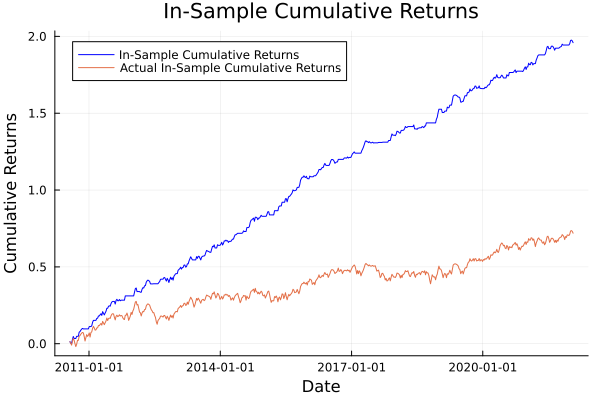

In [50]:
# Plotting in-sample cumulative returns
in_sample_plot = plot(idates, in_sample_cumulative_returns, label="In-Sample Cumulative Returns", color=:blue, title="In-Sample Cumulative Returns", xlabel="Date", ylabel="Cumulative Returns")
plot!(in_sample_plot, idates, cumsum(log_returns[ind_tr]), label="Actual In-Sample Cumulative Returns")
display(in_sample_plot)

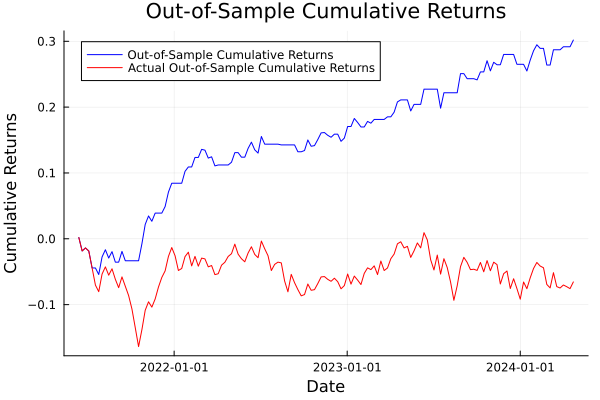

In [51]:
# Plotting out-of-sample cumulative returns
out_of_sample_plot = plot(odates, out_of_sample_cumulative_returns, label="Out-of-Sample Cumulative Returns", color=:blue, title="Out-of-Sample Cumulative Returns", xlabel="Date", ylabel="Cumulative Returns")
plot!(out_of_sample_plot, odates, cumsum(log_returns[ind_te]), label="Actual Out-of-Sample Cumulative Returns", color=:red)
display(out_of_sample_plot)

### Analysis

In [52]:
beta = 1 # Assumed for now

# In-sample and Out-of-sample indices
in_sample_returns = returns[ind_tr]
out_of_sample_returns = returns[ind_te]

# Sharpe Ratio calculation
in_sample_sharpe_ratio = sqrt(52) * mean(in_sample_returns) / std(in_sample_returns)
out_of_sample_sharpe_ratio = sqrt(52) * mean(out_of_sample_returns) / std(out_of_sample_returns)

println("In-Sample Sharpe Ratio: ", in_sample_sharpe_ratio)
println("Out-of-Sample Sharpe Ratio: ", out_of_sample_sharpe_ratio)

# Treynor Ratio calculation, assuming beta = 1 for simplicity
in_sample_treynor_ratio = sqrt(52) * mean(in_sample_returns) / beta
out_of_sample_treynor_ratio = sqrt(52) * mean(out_of_sample_returns) / beta

println("In-Sample Treynor Ratio: ", in_sample_treynor_ratio)
println("Out-of-Sample Treynor Ratio: ", out_of_sample_treynor_ratio)


In-Sample Sharpe Ratio: 2.4857495827240856
Out-of-Sample Sharpe Ratio: 1.4002133114273678
In-Sample Treynor Ratio: 0.023504852359630735
Out-of-Sample Treynor Ratio: 0.01451128899293313


In [53]:
# In-sample accuracy
in_sample_accuracy = mean(binary_predictions[ind_tr] .== binary_outcomes[ind_tr])

# Out-of-sample accuracy
out_of_sample_accuracy = mean(binary_predictions[ind_te] .== binary_outcomes[ind_te])

println("In-Sample Accuracy: ", in_sample_accuracy)
println("Out-of-Sample Accuracy: ", out_of_sample_accuracy)

logipredictions = binary_predictions[ind_te];

In-Sample Accuracy: 0.6722129783693843
Out-of-Sample Accuracy: 0.6333333333333333


.

# Model 3 - XG Boost

In [54]:
# Sort the training indices if not already sorted
sorted_ind_tr = sort(ind_tr)

# Split sorted_ind_tr into 5 folds
training_folds = []
fold_size = ceil(Int, length(sorted_ind_tr) / 5)

for i in 0:4
    start_idx = i * fold_size + 1
    end_idx = min((i + 1) * fold_size, length(sorted_ind_tr))
    push!(training_folds, sorted_ind_tr[start_idx:end_idx])
end

# Confirm the distribution of indices in each fold
for (i, fold) in enumerate(training_folds)
    println("Training fold ", i, ": ", length(fold), " indices")
end


Training fold 1: 121 indices
Training fold 2: 121 indices
Training fold 3: 121 indices
Training fold 4: 121 indices
Training fold 5: 117 indices


In [55]:
# Clear the existing test folds
test_folds = []

# Split ind_te into approximately equal parts for 5 folds
fold_size = ceil(Int, length(ind_te) / 5)
for i in 0:4
    start_idx = i * fold_size + 1
    end_idx = min((i + 1) * fold_size, length(ind_te))
    push!(test_folds, ind_te[start_idx:end_idx])
end

# Confirm the new distribution
for (i, fold) in enumerate(test_folds)
    println("Test fold ", i, ": ", length(fold))
end

Test fold 1: 30
Test fold 2: 30
Test fold 3: 30
Test fold 4: 30
Test fold 5: 30


In [56]:
# Calculate the length of in-sample and out-of-sample periods
ilength = length(ind_tr)
olength = length(ind_te)

# Extract dates for in-sample and out-of-sample periods
idates = dates[1:ilength]
odates = dates[end-olength+1:end];

### Training

In [57]:
# Map these arrays to kfold_X and kfold_Xt variables properly
kfold_1 = training_folds[1]
kfold_2 = training_folds[2]
kfold_3 = training_folds[3]
kfold_4 = training_folds[4]
kfold_5 = training_folds[5]

kfold_1t = test_folds[1]
kfold_2t = test_folds[2]
kfold_3t = test_folds[3]
kfold_4t = test_folds[4]
kfold_5t = test_folds[5]

605:5:750

In [58]:
# Prepare training data for prediction
dtrain_1 = DMatrix(x[kfold_1,:], label = y[kfold_1])
dtrain_2 = DMatrix(x[kfold_2,:], label = y[kfold_2])
dtrain_3 = DMatrix(x[kfold_3,:], label = y[kfold_3])
dtrain_4 = DMatrix(x[kfold_4,:], label = y[kfold_4])
dtrain_5 = DMatrix(x[kfold_5,:], label = y[kfold_5])

# Train the model for each fold
boost_1 = xgboost(dtrain_1, num_round=100, eta=0.1, max_depth=3, min_child_weight=10, objective="reg:squarederror")
boost_2 = xgboost(dtrain_2, num_round=100, eta=0.1, max_depth=3, min_child_weight=10, objective="reg:squarederror")
boost_3 = xgboost(dtrain_3, num_round=100, eta=0.1, max_depth=3, min_child_weight=10, objective="reg:squarederror")
boost_4 = xgboost(dtrain_4, num_round=100, eta=0.1, max_depth=3, min_child_weight=10, objective="reg:squarederror")
boost_5 = xgboost(dtrain_5, num_round=100, eta=0.1, max_depth=3, min_child_weight=10, objective="reg:squarederror")

[ Info: XGBoost: starting training.
[ Info: [1]	train-rmse:0.01372684232332032
[ Info: [2]	train-rmse:0.01246804339137225
[ Info: [3]	train-rmse:0.01132718526345668
[ Info: [4]	train-rmse:0.01029477886976446
[ Info: [5]	train-rmse:0.00936082006739006
[ Info: [6]	train-rmse:0.00851022859985679
[ Info: [7]	train-rmse:0.00774196444102010
[ Info: [8]	train-rmse:0.00704629317853174
[ Info: [9]	train-rmse:0.00641741818816628
[ Info: [10]	train-rmse:0.00584685855021601
[ Info: [11]	train-rmse:0.00533156625723151
[ Info: [12]	train-rmse:0.00486403329265116
[ Info: [13]	train-rmse:0.00443930648929467
[ Info: [14]	train-rmse:0.00405588285846345
[ Info: [15]	train-rmse:0.00370985429230540
[ Info: [16]	train-rmse:0.00339694867139340
[ Info: [17]	train-rmse:0.00311610813532587
[ Info: [18]	train-rmse:0.00286441116145264
[ Info: [19]	train-rmse:0.00263675908317930
[ Info: [20]	train-rmse:0.00243255688834660
[ Info: [21]	train-rmse:0.00224920312645371
[ Info: [22]	train-rmse:0.00208447220452985
[ Inf

[ Info: [10]	train-rmse:0.00543787856108398
[ Info: [11]	train-rmse:0.00496366585687297
[ Info: [12]	train-rmse:0.00453354275409326
[ Info: [13]	train-rmse:0.00414501507723423
[ Info: [14]	train-rmse:0.00379532379609163
[ Info: [15]	train-rmse:0.00348136804091410
[ Info: [16]	train-rmse:0.00319827325642272
[ Info: [17]	train-rmse:0.00294467494822947
[ Info: [18]	train-rmse:0.00271556100206613
[ Info: [19]	train-rmse:0.00251071771898274
[ Info: [20]	train-rmse:0.00232740067071224
[ Info: [21]	train-rmse:0.00216305066895819
[ Info: [22]	train-rmse:0.00201878773466403
[ Info: [23]	train-rmse:0.00188907859279829
[ Info: [24]	train-rmse:0.00177077174249335
[ Info: [25]	train-rmse:0.00166954895880585
[ Info: [26]	train-rmse:0.00157903665091321
[ Info: [27]	train-rmse:0.00150019298482728
[ Info: [28]	train-rmse:0.00143124478479377
[ Info: [29]	train-rmse:0.00136536645514819
[ Info: [30]	train-rmse:0.00131235025870315
[ Info: [31]	train-rmse:0.00126728060859760
[ Info: [32]	train-rmse:0.001226

[ Info: [10]	train-rmse:0.00528533696696152
[ Info: [11]	train-rmse:0.00482868413178576
[ Info: [12]	train-rmse:0.00441710384048080
[ Info: [13]	train-rmse:0.00404367877870864
[ Info: [14]	train-rmse:0.00371424180022820
[ Info: [15]	train-rmse:0.00340981226900857
[ Info: [16]	train-rmse:0.00313533052792000
[ Info: [17]	train-rmse:0.00288933456011918
[ Info: [18]	train-rmse:0.00266913989308803
[ Info: [19]	train-rmse:0.00247439273688094
[ Info: [20]	train-rmse:0.00229789766281294
[ Info: [21]	train-rmse:0.00214295523780795
[ Info: [22]	train-rmse:0.00200181755862929
[ Info: [23]	train-rmse:0.00187739669169669
[ Info: [24]	train-rmse:0.00176963935369720
[ Info: [25]	train-rmse:0.00167077607482611
[ Info: [26]	train-rmse:0.00158827457934038
[ Info: [27]	train-rmse:0.00151563678517444
[ Info: [28]	train-rmse:0.00144849315303999
[ Info: [29]	train-rmse:0.00139139566623516
[ Info: [30]	train-rmse:0.00134028503522233
[ Info: [31]	train-rmse:0.00129470413092906
[ Info: [32]	train-rmse:0.001251

[ Info: [16]	train-rmse:0.00349053079285197
[ Info: [17]	train-rmse:0.00320474380626299
[ Info: [18]	train-rmse:0.00294621208833556
[ Info: [19]	train-rmse:0.00271208545107142
[ Info: [20]	train-rmse:0.00250383457604032
[ Info: [21]	train-rmse:0.00231614657774856
[ Info: [22]	train-rmse:0.00214771236557203
[ Info: [23]	train-rmse:0.00199944543743056
[ Info: [24]	train-rmse:0.00186546187396748
[ Info: [25]	train-rmse:0.00174805309030991
[ Info: [26]	train-rmse:0.00164183558318253
[ Info: [27]	train-rmse:0.00154920654698501
[ Info: [28]	train-rmse:0.00146698563796765
[ Info: [29]	train-rmse:0.00139475541620392
[ Info: [30]	train-rmse:0.00133250304991636
[ Info: [31]	train-rmse:0.00127779559180606
[ Info: [32]	train-rmse:0.00122894828539272
[ Info: [33]	train-rmse:0.00118501563804067
[ Info: [34]	train-rmse:0.00114751086682887
[ Info: [35]	train-rmse:0.00111220765171026
[ Info: [36]	train-rmse:0.00108433077187340
[ Info: [37]	train-rmse:0.00105797519300058
[ Info: [38]	train-rmse:0.001031

[ Info: [48]	train-rmse:0.00098026940392005
[ Info: [49]	train-rmse:0.00096651250441967
[ Info: [50]	train-rmse:0.00095783349109059
[ Info: [51]	train-rmse:0.00095002290812096
[ Info: [52]	train-rmse:0.00093292916796451
[ Info: [53]	train-rmse:0.00092573614301637
[ Info: [54]	train-rmse:0.00091861442541575
[ Info: [55]	train-rmse:0.00090907408467011
[ Info: [56]	train-rmse:0.00089301783459128
[ Info: [57]	train-rmse:0.00088431682191894
[ Info: [58]	train-rmse:0.00087813400030288
[ Info: [59]	train-rmse:0.00086690743471907
[ Info: [60]	train-rmse:0.00085317155867891
[ Info: [61]	train-rmse:0.00084534474792666
[ Info: [62]	train-rmse:0.00083597030728780
[ Info: [63]	train-rmse:0.00081998556054467
[ Info: [64]	train-rmse:0.00081464204027491
[ Info: [65]	train-rmse:0.00080891902045206
[ Info: [66]	train-rmse:0.00079249290158360
[ Info: [67]	train-rmse:0.00077976680721006
[ Info: [68]	train-rmse:0.00077355348800510
[ Info: [69]	train-rmse:0.00076859271453214
[ Info: [70]	train-rmse:0.000758

Booster()

In [59]:
# Prepare test data for prediction using indices to map the indices
dtrain_1 = DMatrix(x[kfold_1,:]);
dtrain_2 = DMatrix(x[kfold_2,:]);
dtrain_3 = DMatrix(x[kfold_3,:]);
dtrain_4 = DMatrix(x[kfold_4,:]);
dtrain_5 = DMatrix(x[kfold_5,:]);

In [60]:
# Predict using the trained models
vp1 = XGBoost.predict(boost_1, dtrain_1);
vp2 = XGBoost.predict(boost_2, dtrain_2);
vp3 = XGBoost.predict(boost_3, dtrain_3);
vp4 = XGBoost.predict(boost_4, dtrain_4);
vp5 = XGBoost.predict(boost_5, dtrain_5);

In [61]:
# Prepare predictions
ipreds = vcat(vp4, vp5, vp2, vp3, vp1)  # Concatenate predictions in the preferred order
ibets = sign.(ipreds);  # Calculate the sign of in-sample predictions
length(ibets)

601

### Graphs

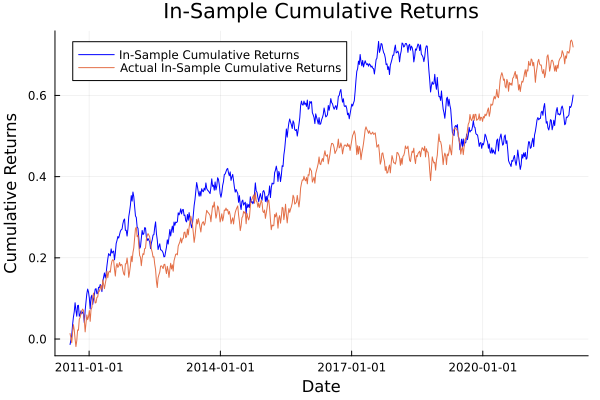

In [62]:
# Plot in-sample cumulative returns
in_sample_plotsxgb = plot(idates, cumsum(ibets .* y[ind_tr], dims=1), legend=:topleft, fmt=:png,label="In-Sample Cumulative Returns", color=:blue, title="In-Sample Cumulative Returns", xlabel="Date", ylabel="Cumulative Returns")
plot!(in_sample_plotsxgb, idates, cumsum(log_returns[ind_tr]), label="Actual In-Sample Cumulative Returns")
display(in_sample_plotsxgb)

In [63]:
# Prepare test data for prediction using indices to map the indices
dtest_1 = DMatrix(x[kfold_1t,:]);
dtest_2 = DMatrix(x[kfold_2t,:]);
dtest_3 = DMatrix(x[kfold_3t,:]);
dtest_4 = DMatrix(x[kfold_4t,:]);
dtest_5 = DMatrix(x[kfold_5t,:]);

In [64]:
# Predict using the trained models
yp1 = XGBoost.predict(boost_1, dtest_1);
yp2 = XGBoost.predict(boost_2, dtest_2);
yp3 = XGBoost.predict(boost_3, dtest_3);
yp4 = XGBoost.predict(boost_4, dtest_4);
yp5 = XGBoost.predict(boost_5, dtest_5);

In [65]:
# Prepare predictions
opreds = vcat(yp5, yp4, yp2, yp3, yp1)  # Concatenate predictions in the preferred order
obets = sign.(opreds);  # Calculate the sign of in-sample predictions

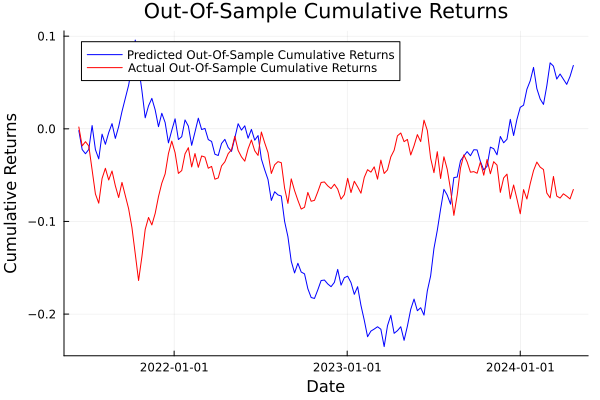

In [66]:
# Plot out-of-sample cumulative returns
out_of_samplexgb = plot(odates, cumsum(obets .* y[ind_te], dims=1), legend=:topleft, fmt=:png, label="Predicted Out-Of-Sample Cumulative Returns", color=:blue, title="Out-Of-Sample Cumulative Returns", xlabel="Date", ylabel="Cumulative Returns")
plot!(out_of_samplexgb, odates, cumsum(log_returns[ind_te]), label="Actual Out-Of-Sample Cumulative Returns", color=:red)
display(out_of_samplexgb)


### Analysis

In [67]:
beta = 1 # Assumed for now

# Calculate Sharpe and Treynor Ratios for in-sample and out-of-sample
in_sample_returns = sign.(ibets) .* y[ind_tr]
out_of_sample_returns = sign.(obets) .* y[ind_te]

in_sample_sharpe_ratio = sqrt(52) * mean(in_sample_returns) / std(in_sample_returns)
out_of_sample_sharpe_ratio = sqrt(52) * mean(out_of_sample_returns) / std(out_of_sample_returns)

in_sample_treynor_ratio = sqrt(52) * mean(in_sample_returns) / beta
out_of_sample_treynor_ratio = sqrt(52) * mean(out_of_sample_returns) / beta

println("In-Sample Sharpe Ratio: ", in_sample_sharpe_ratio)
println("Out-of-Sample Sharpe Ratio: ", out_of_sample_sharpe_ratio)
println("In-Sample Treynor Ratio: ", in_sample_treynor_ratio)
println("Out-of-Sample Treynor Ratio: ", out_of_sample_treynor_ratio)


In-Sample Sharpe Ratio: 0.5031683943581213
Out-of-Sample Sharpe Ratio: 0.22686280742476123
In-Sample Treynor Ratio: 0.007208155469241227
Out-of-Sample Treynor Ratio: 0.0032874533557509197


In [68]:
# Calculate and print accuracies
in_sample_accuracy = mean(sign.(ibets) .== sign.(y[ind_tr]))
out_of_sample_accuracy = mean(sign.(obets) .== sign.(y[ind_te]))

println("In-Sample Accuracy: ", in_sample_accuracy)
println("Out-of-Sample Accuracy: ", out_of_sample_accuracy)

xgbpreds = obets;

In-Sample Accuracy: 0.540765391014975
Out-of-Sample Accuracy: 0.5133333333333333


.

# Model 4 - Random Forest

### Re-preparing Data

In [69]:
# Load FTSE data
start = DateTime(2009, 4, 18)
ftse = dropmissing(DataFrame(yahoo("^FTSE", YahooOpt(period1 = start,interval="1wk"))))
ftse = select!(ftse, Not([:Open, :High, :Low, :Close]));
#Compute log returns
lrt0=log.((ftse.AdjClose[2:end])./(ftse.AdjClose[1:end-1]))
lrt0[ismissing.(lrt0)].=0;
lrt=tanh.(lrt0/0.03)*0.03;  #  truncate at +/- 0.03
rets = (ftse.AdjClose[2:end]./ftse.AdjClose[1:end-1]).-1;
ta=TimeArray(ftse,timestamp=:timestamp);  # convert DataFrame to TimeArray required for routines
# Prepare TimeArray and indicators
ta = TimeArray(ftse, timestamp=:timestamp)
ema5 = ema(ta[:AdjClose], 5)
ema20 = ema(ta[:AdjClose], 20)
macd1 = macd(ta[:AdjClose], 12, 26, 9)
rsi1 = rsi(ta[:AdjClose]);
ftse2 = ftse[1:end, :]
ftse2 = innerjoin(ftse2, DataFrame(ema5), DataFrame(ema20), DataFrame(macd1), DataFrame(rsi1), on=:timestamp)
ftse2 = ftse[34:end, :]
ftse2 = innerjoin(ftse2, DataFrame(ema5), DataFrame(ema20), DataFrame(macd1), DataFrame(rsi1), on=:timestamp)
DataFrames.rename!(ftse2, :AdjClose_ema_5 => :EMA5)
DataFrames.rename!(ftse2, :AdjClose_ema_20 => :EMA20)
DataFrames.rename!(ftse2, :AdjClose_rsi_14 => :RSI)
lrt0=log.((ftse2.AdjClose[2:end])./(ftse2.AdjClose[1:end-1]))
lrt0[ismissing.(lrt0)].=0;
lrt=tanh.(lrt0/0.03)*0.03;  #  truncate at +/- 0.03
#lrt and x_all are already defined as per your earlier code
number_of_lags = 12
# Initialize an empty DataFrame for lagged features
lagged_features = DataFrame()
# Create lagged return features
# Create lagged return features, avoiding initial rows with placeholder zeros
for lag in 1:number_of_lags
    lagged_features[!, Symbol("Lag_", lag)] = [zeros(lag); lrt[1:end-lag]]
end
tech_inds = ftse2[1:end-1,3:9]
# Assuming `lags` and `tech_inds` are already defined DataFrames
if nrow(lagged_features) > nrow(tech_inds)
    lags = lagged_features[1:nrow(tech_inds), :]
end

for col in names(tech_inds)
    lagged_features[!, col] = tech_inds[!, col]
end
x = Matrix(lagged_features)
y = lrt[1:end];

In [70]:
#Remove days when there is no trading
x=x[y.!=0,:];
y=y[y.!=0];

In [71]:
x=convert.(Float32,x);  #  This saves memory and makes computation much faster!!!
y=convert.(Float32,y);
ind_all=1:length(y)
ind_te=5:5:length(y)
ind_tr=ind_all[.!in.(ind_all,[ind_te])];


### Model Estimation

In [72]:
using MLDataUtils
using DecisionTree
using Statistics

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_trees=100, n_subfeatures=3, max_depth=1)

# Number of folds for cross-validation
k = 5

# Perform k-fold cross-validation
kf = kfolds(collect(1:length(y)), k) # Assume 'y' is your target vector

# Arrays to store the RMSE for each fold
fold_metrics = []
all_predictions = []
all_actuals = []

for (train_indices, val_indices) in kf
    # Split the data into training and validation sets
    X_train, y_train = x[train_indices, :], y[train_indices]
    X_val, y_val = x[val_indices, :], y[val_indices]

    # Train the model on the training set
    DecisionTree.fit!(rf, X_train, y_train)

    # Predict on the validation set
    predictions = DecisionTree.predict(rf, X_val)
    push!(all_predictions, predictions)  # Store predictions
    push!(all_actuals, y_val)            # Store actual values

    # Calculate the RMSE for this fold and store it
    rmse = sqrt(mean((y_val - predictions).^2))
    push!(fold_metrics, rmse)
end

# Calculate the average RMSE across all folds
average_rmse = mean(fold_metrics)
println("Average RMSE across all folds: $average_rmse")


Average RMSE across all folds: 0.014210279


In [73]:
for preds in all_predictions
    #println(preds)
end

In [74]:
# If you want to see all predictions together, flatten the arrays
flat_predictions = vcat(all_predictions)
flat_actuals = vcat(all_actuals);
#println("\nAll predictions:")
#println(flat_predictions)

# Optionally, compare predictions with actual values
#println("\nActual values:")
#println(flat_actuals)

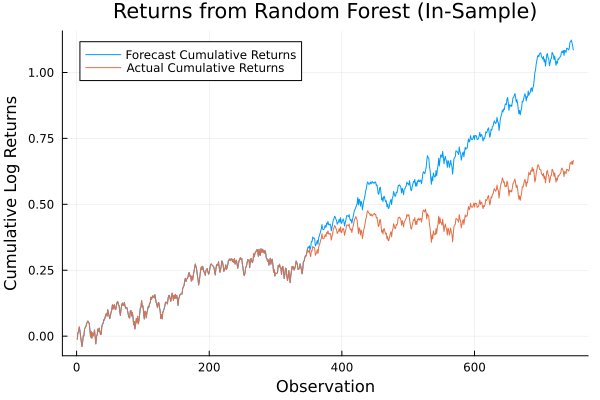

In [75]:
using Plots

# Train the Random Forest on the entire dataset to get in-sample predictions
DecisionTree.fit!(rf, x, y)

# Predict on the in-sample data (the entire dataset)
in_sample_predictions = DecisionTree.predict(rf, x)

# For plotting purposes, we assume that the sign of the predictions is used as the 'bets'
# This may need to be adjusted to fit your specific strategy or use case
in_sample_bets = sign.(in_sample_predictions)

# Calculate cumulative returns based on the model's in-sample predictions
# You should replace `y` with log returns if it's not already in that format
cumulative_forecast_returns = cumsum(in_sample_bets .* y)

# Calculate actual cumulative returns
actual_cumulative_returns = cumsum(y)

# Plot cumulative returns
plot(cumulative_forecast_returns, legend=:topleft, fmt=:png, 
     label="Forecast Cumulative Returns", title="Returns from Random Forest (In-Sample)", 
     xlabel="Observation", ylabel="Cumulative Log Returns")

# Overlay the plot with actual cumulative returns
plot!(actual_cumulative_returns, label="Actual Cumulative Returns")

In [76]:
actual_cumulative_returns = cumsum(y);
cumulative_forecast_returns = cumsum(in_sample_bets .* y);

In [77]:
using Statistics

# Assuming `y` contains log returns and `in_sample_bets` represents the trading strategy bets

# Calculate annualized returns for actual and forecasted
annualized_actual_returns = mean(y) * 52
annualized_forecasted_returns = mean(in_sample_bets .* y) * 52

# Calculate annualized standard deviation for actual and forecasted
annualized_actual_std_dev = std(y) * sqrt(52)
annualized_forecasted_std_dev = std(in_sample_bets .* y) * sqrt(52)

# Assuming the risk-free rate is zero for this calculation
risk_free_rate = 0.0

# Sharpe Ratio calculation for actual returns
sharpe_ratio_actual = (annualized_actual_returns - risk_free_rate) / annualized_actual_std_dev

# Sharpe Ratio calculation for forecasted returns
sharpe_ratio_forecasted = (annualized_forecasted_returns - risk_free_rate) / annualized_forecasted_std_dev

println("In-Sample Sharpe Ratio for Actual Returns: $sharpe_ratio_actual")
println("In-Sample Sharpe Ratio for Forecasted Returns: $sharpe_ratio_forecasted")

In-Sample Sharpe Ratio for Actual Returns: 0.446881336253227
In-Sample Sharpe Ratio for Forecasted Returns: 0.7304848163002802


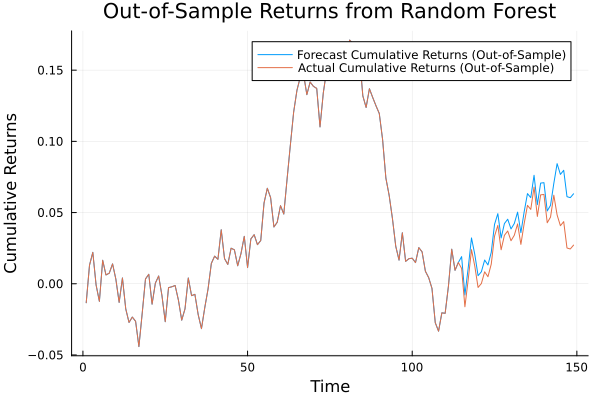

In [78]:
using Plots

# Assume the full dataset `x` and `y` are available, and you have
# designated training indices `ind_tr` and testing indices `ind_te`

# Train the model on the full training dataset
DecisionTree.fit!(rf, x[ind_tr, :], y[ind_tr])

# Predict on the full testing dataset
test_predictions = DecisionTree.predict(rf, x[ind_te, :])

# Assuming `y` contains the log returns
# Calculate the sign of the predictions as betting decisions
bets_test = sign.(test_predictions)

# Calculate cumulative returns based on the model's test predictions
cumulative_returns_test = cumsum(bets_test .* y[ind_te])

# Calculate the actual cumulative returns for the testing data
actual_cumulative_returns_test = cumsum(y[ind_te])

# Plot the cumulative returns for the testing data
plot(cumulative_returns_test, label="Forecast Cumulative Returns (Out-of-Sample)",
     title="Out-of-Sample Returns from Random Forest", xlabel="Time", ylabel="Cumulative Returns")

# Overlay with actual cumulative returns
plot!(actual_cumulative_returns_test, label="Actual Cumulative Returns (Out-of-Sample)")


In [79]:
actual_cumulative_returns_test = cumsum(y[ind_te])
cumulative_returns_test = cumsum(bets_test .* y[ind_te]);

In [80]:
# Calculate the annualized returns and standard deviation for Sharpe Ratio
annualized_test_returns = mean(bets_test .* y[ind_te]) * 52
annualized_actual_returns = mean(y[ind_te]) * 52
annualized_test_std_dev = std(bets_test .* y[ind_te]) * sqrt(52)
annualized_actual_std_dev = std(y[ind_te]) * sqrt(52)

# Assuming the risk-free rate is zero for this calculation
risk_free_rate = 0.0

# Sharpe Ratio calculation for test predictions and actual returns
sharpe_ratio_test = (annualized_test_returns - risk_free_rate) / annualized_test_std_dev
sharpe_ratio_actual = (annualized_actual_returns - risk_free_rate) / annualized_actual_std_dev


# Display Sharpe Ratios in the console

println("Out-of-Sample Sharpe Ratio (Actual): $sharpe_ratio_actual")
println("Out-of-Sample Sharpe Ratio (Forecasted): $sharpe_ratio_test")

Out-of-Sample Sharpe Ratio (Actual): 0.09294587461192481
Out-of-Sample Sharpe Ratio (Forecasted): 0.21649775188820414


In [81]:
#Calculationg Beta
market_returns = actual_cumulative_returns_test[1:end]
#x_market = market_returns[inds] 
beta = cov(cumulative_returns_test, market_returns) / (var(market_returns))

0.9924557f0

In [82]:
treynor_ratio1 = (mean(cumulative_returns_test*10) / beta)
println("Treynor Ratio: ", treynor_ratio1)

Treynor Ratio: 0.43676066


In [83]:
excess_returns = y[ind_te] .- (risk_free_rate / 52)  # Convert annual risk-free rate to weekly
annualized_excess_returns = mean(excess_returns) * 52  # Annualize weekly returns

treynor_ratio_oos = annualized_excess_returns / beta

0.00954033033474536

.

# Model 5 - SVM

### Data Prep

In [84]:
# Load FTSE data
start = DateTime(2009, 4, 18)
ftse = dropmissing(DataFrame(yahoo("^FTSE", YahooOpt(period1 = start,interval="1wk"))))
ftse = select!(ftse, Not([:Open, :High, :Low, :Close]));
#Compute log returns
lrt0=log.((ftse.AdjClose[2:end])./(ftse.AdjClose[1:end-1]))
lrt0[ismissing.(lrt0)].=0;
lrt=tanh.(lrt0/0.03)*0.03;  #  truncate at +/- 0.03
rets = (ftse.AdjClose[2:end]./ftse.AdjClose[1:end-1]).-1;
ta=TimeArray(ftse,timestamp=:timestamp);  # convert DataFrame to TimeArray required for routines
# Prepare TimeArray and indicators
ta = TimeArray(ftse, timestamp=:timestamp)
ema5 = ema(ta[:AdjClose], 5)
ema20 = ema(ta[:AdjClose], 20)
macd1 = macd(ta[:AdjClose], 12, 26, 9)
rsi1 = rsi(ta[:AdjClose]);
ftse2 = ftse[1:end, :]
ftse2 = innerjoin(ftse2, DataFrame(ema5), DataFrame(ema20), DataFrame(macd1), DataFrame(rsi1), on=:timestamp)
ftse2 = ftse[34:end, :]
ftse2 = innerjoin(ftse2, DataFrame(ema5), DataFrame(ema20), DataFrame(macd1), DataFrame(rsi1), on=:timestamp)
DataFrames.rename!(ftse2, :AdjClose_ema_5 => :EMA5)
DataFrames.rename!(ftse2, :AdjClose_ema_20 => :EMA20)
DataFrames.rename!(ftse2, :AdjClose_rsi_14 => :RSI)
lrt0=log.((ftse2.AdjClose[2:end])./(ftse2.AdjClose[1:end-1]))
lrt0[ismissing.(lrt0)].=0;
lrt=tanh.(lrt0/0.03)*0.03;  #  truncate at +/- 0.03
#lrt and x_all are already defined as per your earlier code
number_of_lags = 12
# Initialize an empty DataFrame for lagged features
lagged_features = DataFrame()
# Create lagged return features
# Create lagged return features, avoiding initial rows with placeholder zeros
for lag in 1:number_of_lags
    lagged_features[!, Symbol("Lag_", lag)] = [zeros(lag); lrt[1:end-lag]]
end
tech_inds = ftse2[1:end-1,3:9]
# Assuming `lags` and `tech_inds` are already defined DataFrames
if nrow(lagged_features) > nrow(tech_inds)
    lags = lagged_features[1:nrow(tech_inds), :]
end

for col in names(tech_inds)
    lagged_features[!, col] = tech_inds[!, col]
end
x = Matrix(lagged_features)
y = lrt[1:end];

#Remove days when there is no trading
x=x[y.!=0,:];
y=y[y.!=0];

x=convert.(Float32,x);  #  This saves memory and makes computation much faster!!!
y=convert.(Float32,y);
ind_all=1:length(y)
ind_te=5:5:length(y)
ind_tr=ind_all[.!in.(ind_all,[ind_te])];


In [85]:
using LIBSVM

In [86]:
y_SVM=2*(y.>=0).-1; #convert "Up"/"Down" to +/- 1's

In [87]:
# set the number of folds for cross-validation
k = 5

# calculate the fold size
fold_size = Int(ceil(length(ind_tr)/k))

# initialize the results vector
cv_results = zeros(k)
svm_model=nothing

# perform k-fold cross-validation
for i in 1:k
    # calculate the indices for the current fold
    fold_indices = (i-1)*fold_size+1 : min(i*fold_size, length(ind_tr))
    train_indices = setdiff(1:length(ind_tr), fold_indices)
    
    
    # train the SVM model
    svm_model_fold= svmtrain(x[train_indices,:]', y[train_indices]); 
    
    # make predictions on the test (fold) data
    svm_preds_test,svm_info=sv_predict=svmpredict(svm_model_fold,x[fold_indices,:]');

    # calculate the RMSE for this fold
    cv_results[i] = sqrt(mean((svm_preds_test - y[fold_indices]).^2))
    
    # assign the trained model to svm_model
    svm_model= svm_model_fold
  
end

# calculate the average RMSE across all folds
avg_rmse = mean(cv_results)

0.020829033479094504

In [88]:
sv_preds,sv_info=sv_predict=svmpredict(svm_model,x');
sv_preds=vec(sv_preds); # Predictions
sv_bets=sign.(sv_preds);

In [89]:
# Train the SVM model
svm_model = svmtrain(x', y_SVM) 

# Make predictions with the SVM model
predictions = svmpredict(svm_model, x')[1];

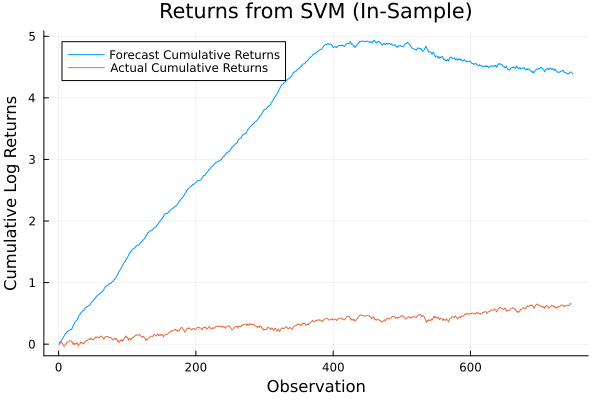

In [90]:
svm_model = svmtrain(x', y_SVM)
in_sample_predictions, _ = svmpredict(svm_model, x')
in_sample_bets = sign.(in_sample_predictions)
cumulative_forecast_returns = cumsum(in_sample_bets .* lrt[1:749])
actual_cumulative_returns = cumsum(lrt[1:747])

# Plot cumulative returns
plot(cumulative_forecast_returns, legend=:topleft, fmt=:png, 
     label="Forecast Cumulative Returns", title="Returns from SVM (In-Sample)", 
     xlabel="Observation", ylabel="Cumulative Log Returns")

# Overlay the plot with actual cumulative returns
plot!(actual_cumulative_returns, label="Actual Cumulative Returns")


In [91]:
# Prepare the training and testing data
x_train = x[ind_tr, :]
y_train = y_SVM[ind_tr]
x_test = x[ind_te, :]
ind_te

5:5:745

In [92]:
y_train = y_SVM[ind_tr];

In [93]:
# Train the SVM model on the full training dataset
svm_model = svmtrain(x_train', y_train);

In [94]:
# Predict on the full testing dataset
test_predictions, _ = svmpredict(svm_model, x_test');

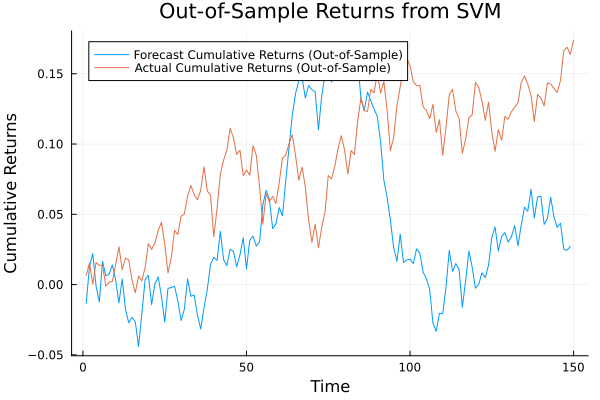

In [95]:
# Convert raw outputs to binary betting decisions
# If the SVM output is already binary labels, this step might be unnecessary
bets_testsvm = sign.(test_predictions)

# Assuming `y` contains the log returns and is properly aligned with `x`
# Calculate the cumulative returns based on the model's test predictions
cumulative_returns_test = cumsum(bets_testsvm .* y[ind_te])

# Calculate the actual cumulative returns for the testing data
actual_cumulative_returns_test = cumsum(y[598:747])

# Plot the cumulative returns for the testing data
plot(cumulative_returns_test, label="Forecast Cumulative Returns (Out-of-Sample)",
     title="Out-of-Sample Returns from SVM", xlabel="Time", ylabel="Cumulative Returns", legend=:topleft)

# Overlay with actual cumulative returns
plot!(actual_cumulative_returns_test, label="Actual Cumulative Returns (Out-of-Sample)")


In [96]:
# Calculate in-sample returns based on the model's predictions
model_returns_in_sample = in_sample_bets .* lrt[1:749]

# Calculate the out-of-sample returns based on the model's predictions
model_returns_out_sample = bets_testsvm .* y_SVM[ind_te];


In [97]:
# Assuming risk-free rate is negligible and beta is 1.0 for both in-sample and out-of-sample
risk_free_rate = 0.0  # Risk-free rate is negligible
beta = 1.0  # Beta is assumed to be 1

# In-sample calculations
mean_daily_return_in_sample = mean(model_returns_in_sample)
std_daily_return_in_sample = std(model_returns_in_sample)
annual_factor = sqrt(52)  # Annualization factor for weekly data

annualized_mean_return_in_sample = mean_daily_return_in_sample * 52
annualized_std_return_in_sample = std_daily_return_in_sample * annual_factor

sharpe_ratio_in_sample = annualized_mean_return_in_sample / annualized_std_return_in_sample
treynor_ratio_in_sample = annualized_mean_return_in_sample / beta  # since beta is 1, this is the same as excess return

println("In-sample Sharpe Ratio: ", sharpe_ratio_in_sample)
println("In-sample Treynor Ratio: ", treynor_ratio_in_sample)

# Out-of-sample calculations
mean_daily_return_out_sample = mean(model_returns_out_sample)
std_daily_return_out_sample = std(model_returns_out_sample)

annualized_mean_return_out_sample = mean_daily_return_out_sample * 52
annualized_std_return_out_sample = std_daily_return_out_sample * annual_factor

sharpe_ratio_out_sample = annualized_mean_return_out_sample / annualized_std_return_out_sample
treynor_ratio_out_sample = annualized_mean_return_out_sample / beta  # since beta is 1, this is the same as excess return

println("Out-of-sample Sharpe Ratio: ", sharpe_ratio_out_sample)
println("Out-of-sample Treynor Ratio: ", treynor_ratio_out_sample)


In-sample Sharpe Ratio: 3.2218554656994427
In-sample Treynor Ratio: 0.3048435719031614
Out-of-sample Sharpe Ratio: 0.24130581805214166
Out-of-sample Treynor Ratio: 1.74496644295302


.

# Neural Network (prep work for ensembling)

In [98]:
ftse3 = ftse[34:end-1, :]
ftse3 = innerjoin(ftse3, DataFrame(ema5), DataFrame(ema20), DataFrame(macd1), DataFrame(rsi1), on=:timestamp)
DataFrames.rename!(ftse3, :AdjClose_ema_5 => :EMA5)
DataFrames.rename!(ftse3, :AdjClose_ema_20 => :EMA20)
DataFrames.rename!(ftse3, :AdjClose_rsi_14 => :RSI)

ftse3[!, :lrt] = lrt

using DataFrames

# Assuming ftse3 is your existing DataFrame
df = select(ftse3, Not(:AdjClose));


In [99]:
N_lags = 12  # or N_lags = 5
# Creating features based on 6 previous time steps
# no. lags: For weekly data, this means looking 7 weeks into the past.

# create features (lags of indicators & log returns) matrix
# No. of rows equal to number of rows in X_raw minus no. of lags
# This matrix will be filled with lagged features

global x=zeros(nrow(df)-N_lags,0)
for col in 2:ncol(df)
    for i=1:N_lags
    global x
        x=[x df[:,col][i:(end-(N_lags+1)+i)]];
    end
end

y = df[N_lags+1:end, :lrt] # label (log returns) matrix
    # These are the values that the model will be trained to predict, 
    # known as labels or targets

# compare x and y with X_raw to confirm lags are calculated correctly
display(x[1, 1:5])
display(x[end, 1:5])
display(y[34])
display(y[end])

5-element Vector{Float64}:
 5.6682482e9
 6.0969885e9
 2.0606875e9
 9.074652e8
 5.0678928e9

5-element Vector{Float64}:
 4.4877066e9
 4.1324659e9
 5.6360803e9
 5.1626663e9
 5.2705393e9

-0.011052094210056068

0.015094530311567895

In [100]:
x=convert.(Float32,x);  #  This saves memory and makes computation much faster!!!
y=convert.(Float32,y);

indices=1:length(y) # includes all indices of the dataset

#We divide the dataset into training (first 85% of the observations) and testing. 
#The training data will be used to train the model using 5 fold cross validation.

# Creating array of indices for the test set.
# Select every 8th index starting from 5th.
ind_test=5:8:length(y) # Subsampling

# Training index
    # Creating the training indices
    # Exclude the test indices from ind_all
ind_train=indices[.!in.(indices,[ind_test])];  # List of indices used for training set

In [101]:
println([length(indices) length(ind_train) length(ind_test)])

[738 646 92]


In [102]:
databatch=[];
for i=1:Int(floor(length(ind_train)/50))
	global databatch
	inds=ind_train[50*(i-1).+(1:50)]
	databatch=[databatch;(x[inds,:]',y[inds]')];
end

In [103]:
m =Chain(Dense(length(x[1,:]),40), BatchNorm(40,relu), Dropout(0.25), Dense(40,40), BatchNorm(40, relu), Dropout(0.25), Dense(40,20), BatchNorm(20,relu), Dense(20,1))

Chain(
  Dense(96 => 40),                      # 3_880 parameters
  BatchNorm(40, relu),                  # 80 parameters, plus 80
  Dropout(0.25),
  Dense(40 => 40),                      # 1_640 parameters
  BatchNorm(40, relu),                  # 80 parameters, plus 80
  Dropout(0.25),
  Dense(40 => 20),                      # 820 parameters
  BatchNorm(20, relu),                  # 40 parameters, plus 40
  Dense(20 => 1),                       # 21 parameters
)         # Total: 14 trainable arrays, 6_561 parameters,
          # plus 6 non-trainable, 200 parameters, summarysize 27.652 KiB.

In [104]:
loss(x1,y1)=mean(((m(x1).*(exp.(y1).-1).-1)').^2)

loss (generic function with 1 method)

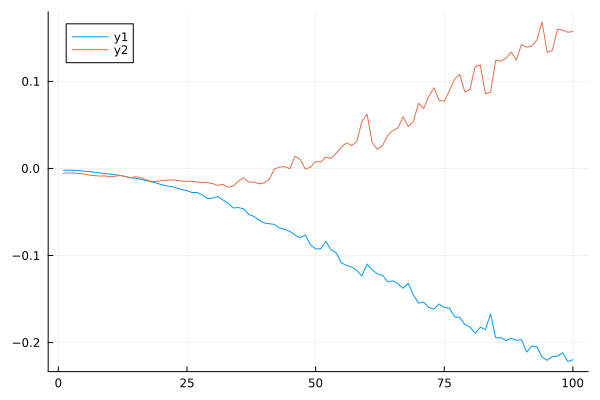

In [105]:
opt=ADAM(0.001)       #(0.00086)  
plot_array=zeros(100,2)
for i=1:100
     Flux.train!(loss,Flux.params(m),databatch,opt)
     loss_train=loss(x[ind_train,:]',y[ind_train,:]')
     loss_test=loss(x[ind_test,:]',y[ind_test,:]')
     plot_array[i,:]=log.([loss_train,loss_test])
end

plot(plot_array)

In [106]:
inds=[ind_train;ind_test]; loss(x[inds,:]',y[inds]')

0.8485673f0

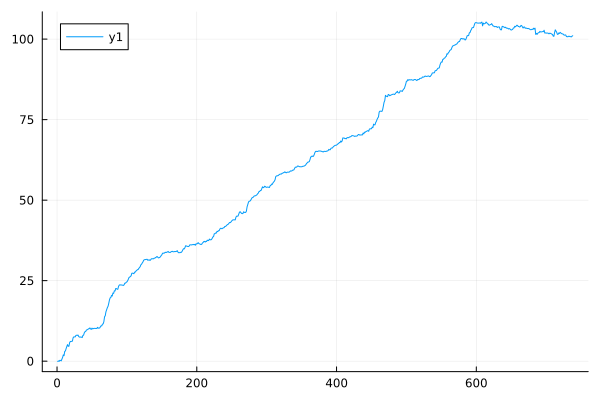

In [107]:
yp=m(x')'; bets=yp;
rtns=bets[inds].*(exp.(y[inds]).-1)
plot(cumsum(rtns,dims=1),legend=:topleft,fmt=png)

In [108]:
sqrt(52)*mean(rtns)/std(rtns)

3.06455671157662

In [109]:
tr_1 = 1:5:length(ind_train)
tr_2 = 2:5:length(ind_train)
tr_3 = 3:5:length(ind_train)
tr_4 = 4:5:length(ind_train)
tr_5 = 5:5:length(ind_train)

5:5:645

In [110]:
kfold_1 = vcat(tr_1,tr_2,tr_3,tr_4);
kfold_1t = vcat(tr_5);
kfold_2 = vcat(tr_1,tr_2,tr_4,tr_5);
kfold_2t = vcat(tr_3);
kfold_3 = vcat(tr_1,tr_2,tr_3,tr_5);
kfold_3t = vcat(tr_4);
kfold_4 = vcat(tr_1,tr_3,tr_4,tr_5);
kfold_4t = vcat(tr_2);
kfold_5 = vcat(tr_2,tr_3,tr_4,tr_5);
kfold_5t = vcat(tr_1);

In [111]:
y[kfold_1t];

In [112]:
# Define the loss function (MSE)
function model_loss(model, x, y)
    return mean(((model(x).*(exp.(y).-1).-1)').^2)
end

model_loss (generic function with 1 method)

In [113]:
# Validation loss
function validation_loss(model, x_val, y_val)
    return mean(((model(x_val).*(exp.(y_val).-1).-1)').^2)
end

validation_loss (generic function with 1 method)

In [114]:
# Function to dynamically adjust the learning rate based on validation loss
function learning_rate(optimizer, current_val_loss, best_val_loss, previous_val_loss, decay_rate, min_lr, cooldown_counter, cooldown, min_delta)
    if cooldown_counter > 0
        cooldown_counter -= 1
    elseif (previous_val_loss - current_val_loss) < min_delta
        new_lr = max(min_lr, decay_rate * optimizer.eta)
        optimizer.eta = new_lr
        cooldown_counter = cooldown
    end
    return cooldown_counter
end

learning_rate (generic function with 1 method)

In [115]:
# Function to train a model with early stopping and dynamic learning rate adjustment
function train_model(model, x_train, y_train, x_val, y_val, opt, epochs=100, batch_size=50)
    best_val_loss = Inf
    previous_val_loss = Inf
    patience = 20
    patience_counter = 0
    cooldown_counter = 0
    cooldown = 5
    min_delta = 1e-4

    for epoch in 1:epochs
        # Shuffle the data at the beginning of each epoch
        indices = shuffle(1:length(y_train))
        x_train_shuffled = x_train[:, indices]
        y_train_shuffled = y_train[indices]

        # Iterate over mini-batches
        num_batches = ceil(Int, length(y_train) / batch_size)
        for i in 1:num_batches
            start_idx = (i - 1) * batch_size + 1
            end_idx = min(i * batch_size, length(y_train))
            x_batch = x_train_shuffled[:, start_idx:end_idx]
            y_batch = y_train_shuffled[start_idx:end_idx]
            Flux.train!((x, y) -> model_loss(model, x, y), Flux.params(model), [(x_batch, y_batch)], opt)
        end

        # Check validation loss for early stopping and learning rate adjustment
        current_val_loss = validation_loss(model, x_val, y_val)
        if current_val_loss < best_val_loss
            best_val_loss = current_val_loss
            previous_val_loss = current_val_loss
            patience_counter = 0
        else
            patience_counter += 1
            if patience_counter >= patience
                println("Early stopping triggered at epoch $epoch")
                break
            end
        end
        
        cooldown_counter = learning_rate(opt, current_val_loss, best_val_loss, previous_val_loss, 0.95, 1e-5, cooldown_counter, cooldown, min_delta)
        previous_val_loss = current_val_loss
    end
end

train_model (generic function with 3 methods)

In [116]:
using Random

# Initialize models and train them 
models = [Chain(Dense(length(x[1,:]),50,relu),Dropout(0.50), Dense(50,50,relu), Dense(50,25,relu),  Dropout(0.50), Dense(25,1)) for _ in 1:5]
opt = ADAM(0.001)  

# Train each model using the respective fold data
for i in 1:length(models)
    train_model(models[i], x[eval(Symbol("kfold_$i")), :]', y[eval(Symbol("kfold_$i"))]', x[eval(Symbol("kfold_$(i)t")), :]', y[eval(Symbol("kfold_$(i)t"))]', opt)
end

# Predictions 
predictions = [model(x[eval(Symbol("kfold_$(i)t")), :]')' for (i, model) in enumerate(models)]
predictions_vector = predictions[:];
predictions_vector = vcat(map(vec, predictions)...)
predictions_float32_vector = Float32.(predictions_vector);


Early stopping triggered at epoch 54


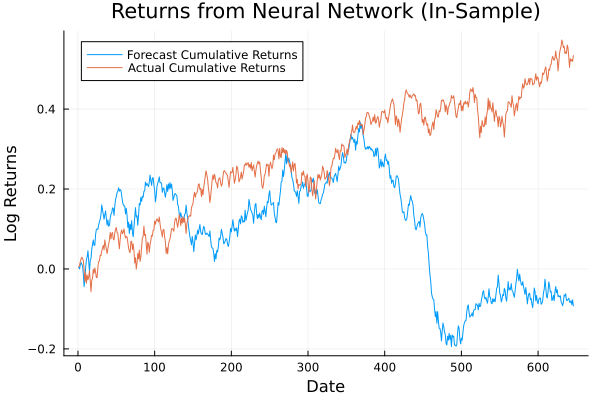

In [117]:
NN_preds = vcat(predictions_vector)
rtn = y[ind_train]
bets_is =sign.(NN_preds)
plot(cumsum(bets_is.*y[ind_train],dims=1),legend=:topleft,fmt=png,label="Forecast Cumulative Returns",title="Returns from Neural Network (In-Sample)",xlabel="Date",ylabel="Log Returns")
plot!(cumsum(y[1:length(ind_train)]),label="Actual Cumulative Returns")

In [118]:
# Sharpe in-Sample
mean(sign.(NN_preds).*y[ind_train])./std(sign.(NN_preds).*y[ind_train])*sqrt(52)

-0.07225543509082179

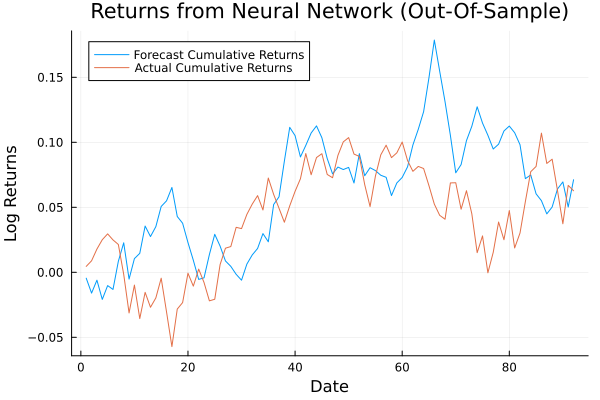

In [119]:
# Predict using each of the models trained
predictions_oos = [models[i](x[ind_test, :]')' for (i, model) in enumerate(models)]
predictions_oos = mean(hcat(predictions_oos));

NN_preds_OOS = vcat(predictions_oos)
rtn_os = y[ind_test]
bets_os =sign.(NN_preds_OOS)
plot(cumsum(bets_os.*y[ind_test],dims=1),legend=:topleft,fmt=png,label="Forecast Cumulative Returns",title="Returns from Neural Network (Out-Of-Sample)",xlabel="Date",ylabel="Log Returns")
plot!(cumsum(y[1:length(ind_test)]),label="Actual Cumulative Returns")

In [120]:
# Sharpe Out-Of-Sample
mean(sign.(NN_preds_OOS).*y[ind_test])./std(sign.(NN_preds_OOS).*y[ind_test])*sqrt(52)

0.39201043345608566

.

# Neural Network Ensembling

### Re-preparing data

In [134]:
# Preparing FTSE Data
# Load FTSE data
start = DateTime(2009, 4, 17)
ftse = dropmissing(DataFrame(yahoo("^FTSE", YahooOpt(period1 = start, interval="1wk"))))
ftse = select!(ftse, Not([:Open, :High, :Low, :Close]));
plot(ftse.timestamp, ftse.AdjClose, legend=:topleft, show=true, fmt=:png, title="FTSE Share Price", xlabel="Time", ylabel="Share Price", label="Share Price")

# Calculate log returns and truncate
lrt0 = log.((ftse.AdjClose[2:end]) ./ (ftse.AdjClose[1:end-1]))
lrt0[ismissing.(lrt0)] .= 0
lrt = tanh.(lrt0 / 0.03) * 0.03
ftse[:, :lrt] = [0; lrt];
rets = (ftse.AdjClose[2:end] ./ ftse.AdjClose[1:end-1]) .- 1;
Plots.plot(cumsum(lrt), label="Truncated Log Returns", legend=:topleft, show=true, fmt=:png, linewidth=2, title="FTSE Log Returns vs Truncated Returns", xlabel="Time", ylabel="Cumulative Return")
plot!(cumsum(lrt0), label="FTSE Log Returns", legend=:topleft, linewidth=2)
ylabel!("Cumulative Return")

ta = TimeArray(ftse, timestamp=:timestamp);  # Convert DataFrame to TimeArray required for routines

# Adding Technical Indicators
# Prepare TimeArray and indicators
ta = TimeArray(ftse, timestamp=:timestamp)
ema5 = ema(ta[:AdjClose], 5)
ema20 = ema(ta[:AdjClose], 20)
macd1 = macd(ta[:AdjClose], 12, 26, 9)
rsi1 = rsi(ta[:AdjClose]);
ftse2 = ftse[34:end, :]  # Align starts by truncating initial rows where indicators are not available
ftse2 = innerjoin(ftse2, DataFrame(ema5), DataFrame(ema20), DataFrame(macd1), DataFrame(rsi1), on=:timestamp)
DataFrames.rename!(ftse2, :AdjClose_ema_5 => :EMA5)
DataFrames.rename!(ftse2, :AdjClose_ema_20 => :EMA20)
DataFrames.rename!(ftse2, :AdjClose_rsi_14 => :RSI)

n_lags = 12

# Initialize an empty DataFrame for lagged return features
lags = DataFrame()

for lag in 1:n_lags
    lags[!, Symbol("Lag_", lag)] = [zeros(lag); lrt[1:end-lag]]
end

tech_inds = ftse2[1:end, 3:10]
if nrow(lags) != nrow(tech_inds)
    resize!(lags, nrow(tech_inds));  # This adjusts lags to have the same number of rows as ftse2
end

# Append each technical indicator from ftse2 to the lags DataFrame
for col in names(tech_inds) 
    lags[!, col] = tech_inds[!, col]
end

y = lags.lrt;
# Filter days with no trading
x = Matrix(lags)
x = x[y .!= 0, :]  # Remove rows where trading is zero as per 'y'
y = y[y .!= 0]  ;   # Also filter 'y' to match 'x'


### Ensembling

In [135]:
# Preprocess predictions for each model
function preprocess_predictions(predictions, threshold=0.5)
    return [x >= threshold ? 1 : -1 for x in predictions]
end

# Apply preprocessing to each model's output
out_of_sample_predictions = preprocess_predictions(out_of_sample_predictions, 0)  # for Linear Ridge
logipredictions = preprocess_predictions(logipredictions, 0.5)  # for Logistic Regression
xgbpreds = preprocess_predictions(xgbpreds, 0)  # for XGB
bets_test = preprocess_predictions(bets_test, 0.5)  # for Random Forest
bets_testsvm = preprocess_predictions(bets_testsvm, 0.5);  # for SVM

# Assuming bets_testsvm has the correct length (150)
reference_length = length(bets_test)  # Use the length of bets_testsvm as the reference

# Adjust out_of_sample_predictions to have the same length as bets_testsvm
if length(out_of_sample_predictions) > reference_length
    out_of_sample_predictions = out_of_sample_predictions[1:reference_length]
end

if length(logipredictions) > reference_length
    logipredictions = logipredictions[1:reference_length]
end

if length(xgbpreds) > reference_length
    xgbpreds = xgbpreds[1:reference_length]
end

if length(bets_testsvm) > reference_length
    bets_testsvm = bets_testsvm[1:reference_length]
end

# Print lengths to verify
println("Length of out_of_sample_predictions: ", length(out_of_sample_predictions))
println("Length of logipredictions: ", length(logipredictions))
println("Length of xgbpreds: ", length(xgbpreds))
println("Length of bets_test: ", length(bets_test))
println("Length of bets_testsvm: ", length(bets_testsvm))

Length of out_of_sample_predictions: 149
Length of logipredictions: 149
Length of xgbpreds: 149
Length of bets_test: 149
Length of bets_testsvm: 149


In [136]:
# Create an ensemble matrix
ensemble_matrix = hcat(out_of_sample_predictions, logipredictions, xgbpreds, bets_test, bets_testsvm);

In [137]:
# Combine ensemble with labels and original inputs (assuming y and x[ind_te,:] are defined correctly)
neural_data_test = hcat(y[ind_te], ensemble_matrix)
neural_matrix_test = hcat(neural_data_test, x[ind_te,:])
neural_matrix_test = convert.(Float32, neural_matrix_test);

In [138]:
# Extract features and labels
Xt = Array(neural_matrix_test[:, 2:end])
yt = 2 * (Array(neural_matrix_test[:, 1]) .>= 0) .- 1
yt = convert.(Float32, yt);

In [139]:
# Neural Network Model Definition
input_size = size(Xt, 2)  # Dynamically assign input size
m = Chain(
    Dense(input_size, 40, relu),
    BatchNorm(40),
    Dropout(0.25),
    Dense(40, 40, relu),
    BatchNorm(40),
    Dropout(0.25),
    Dense(40, 20, relu),
    BatchNorm(20),
    Dense(20, 1)
)

Chain(
  Dense(25 => 40, relu),                # 1_040 parameters
  BatchNorm(40),                        # 80 parameters, plus 80
  Dropout(0.25),
  Dense(40 => 40, relu),                # 1_640 parameters
  BatchNorm(40),                        # 80 parameters, plus 80
  Dropout(0.25),
  Dense(40 => 20, relu),                # 820 parameters
  BatchNorm(20),                        # 40 parameters, plus 40
  Dense(20 => 1),                       # 21 parameters
)         # Total: 14 trainable arrays, 3_721 parameters,
          # plus 6 non-trainable, 200 parameters, summarysize 16.559 KiB.

In [140]:
# Custom loss function
loss(x, y) = mean((m(x) .* y .- 1).^2)

loss (generic function with 1 method)

In [141]:
# Training the model
opt = ADAM(0.001)
data = [(Xt', yt)]
Flux.train!(loss, Flux.params(m), data, opt)

# Implement the training loop with logging for debugging
for i = 1:100
    Flux.train!(loss, Flux.params(m), data, opt)
    loss_train = loss(Xt', yt);  # Update to use your data splitting
    println("Iteration $i, Training Loss: $loss_train")
end

Iteration 1, Training Loss: 3.5236561
Iteration 2, Training Loss: 2.2026453
Iteration 3, Training Loss: 1.4612385
Iteration 4, Training Loss: 1.1806371
Iteration 5, Training Loss: 1.0734535
Iteration 6, Training Loss: 1.039477
Iteration 7, Training Loss: 1.0409434
Iteration 8, Training Loss: 1.0543795
Iteration 9, Training Loss: 1.0516728
Iteration 10, Training Loss: 1.0502086
Iteration 11, Training Loss: 1.0546538
Iteration 12, Training Loss: 1.053528
Iteration 13, Training Loss: 1.0526489
Iteration 14, Training Loss: 1.054103
Iteration 15, Training Loss: 1.0569628
Iteration 16, Training Loss: 1.0574343
Iteration 17, Training Loss: 1.0585355
Iteration 18, Training Loss: 1.0630734
Iteration 19, Training Loss: 1.0711974
Iteration 20, Training Loss: 1.0791156
Iteration 21, Training Loss: 1.0798973
Iteration 22, Training Loss: 1.0795692
Iteration 23, Training Loss: 1.0859993
Iteration 24, Training Loss: 1.08853
Iteration 25, Training Loss: 1.0899678
Iteration 26, Training Loss: 1.0923322


In [142]:
# Evaluate performance
nn_scores = vec(m(Xt'))
nn_preds = sign.(nn_scores)
println("Accuracy: ", mean(nn_preds .== yt))

Accuracy: 0.5234899328859061


In [143]:
# Trading analysis function
function trading_performance(predictions, returns)
    cum_returns = cumsum(predictions .* returns)
    sharpe_ratio = mean(predictions .* returns) / std(predictions .* returns) * sqrt(52)
    return cum_returns, sharpe_ratio
end

trading_performance (generic function with 1 method)

In [144]:
# Calculate performance metrics
rtn2 = y[ind_te]  # Assuming rtn2 is the return array corresponding to ind_te
long_short_returns, long_short_sharpe = trading_performance(nn_preds, rtn2)
proportional_returns, proportional_sharpe = trading_performance(nn_scores * 3, rtn2);

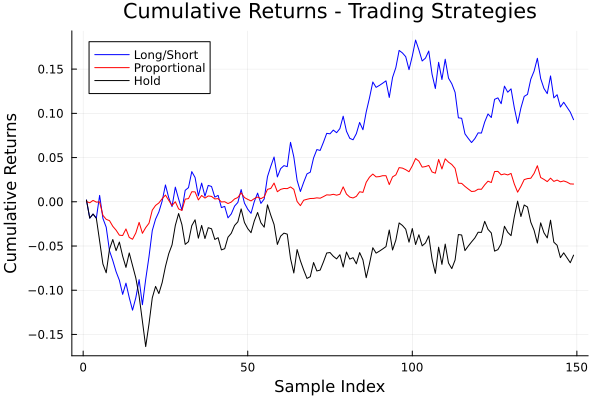

In [145]:
# Plot cumulative returns
plot(long_short_returns, label="Long/Short", color="blue", title="Cumulative Returns - Trading Strategies", xlabel="Sample Index", ylabel="Cumulative Returns", legend=:topleft)
plot!(proportional_returns, label="Proportional", color="red")
plot!(cumsum(rtn2), label="Hold", color="black")

In [146]:
# Assuming a beta value for the portfolio (typically calculated via regression against a market index)
portfolio_beta = 1.0  # Placeholder value

# Update Treynor Ratio calculations
function treynor_ratio(returns, beta, risk_free_rate)
    average_returns = mean(returns .- risk_free_rate)
    return average_returns / (std(returns) * beta) * sqrt(52)
end

# Comprehensive metrics display
println("Accuracy: ", mean(nn_preds .== yt))
println("Sharpe Ratio (Long-Short): ", long_short_sharpe)
println("Sharpe Ratio (Proportional): ", proportional_sharpe)

# Calculate Treynor Ratio for both strategies
treynor_long_short = treynor_ratio(nn_preds .* rtn2, portfolio_beta)
treynor_proportional = treynor_ratio((nn_scores * 3) .* rtn2, portfolio_beta)
println("Treynor Ratio (Long-Short): ", treynor_long_short)
println("Treynor Ratio (Proportional): ", treynor_proportional)


Accuracy: 0.5234899328859061
Sharpe Ratio (Long-Short): 0.3097401448232795
Sharpe Ratio (Proportional): 0.1683434826105973
Treynor Ratio (Long-Short): 0.3097401448232795
Treynor Ratio (Proportional): 0.1683434826105973
